<a href="https://colab.research.google.com/github/akshayadik/nlp-capstone/blob/main/AUTOMATIC_TICKET_ASSIGNMENT-akshay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem
Manual assignment of incidents is time consuming and requires human efforts. There may be mistakes due to human errors and resource consumption is carried out ineffectively because of the misaddressing. On the other hand, manual assignment increases the response and resolution times which result in user satisfaction deterioration / poor customer service.

### 1. Problem interpretation
- Understand the data
- Make an abstract or an overview based on your approach
- Break the problem into smaller tasks
- Discuss among your teammates and share responsibilities

# Abstract

An attempt at Leveraging Machine Learning and Artifical intelligence to automatically classify tickets and assign them to the right owner in a timely manner to save effort, increase user satifaction and improve throughput in the ticketing pipeline of an organization 

### 2. Data analysis and preprocessing: Visual displays are powerful when used well, so think carefully about the information the display.
- Include any insightful visualization
- Share and explain particularly meaningful features, interactions or summary of data
- Display examples to input in your model
- Explain changes to be incorporated into data so that it becomes ready for the model
- Exploring the given Data files
- Understanding the structure of data
- Missing points in data
- Finding inconsistencies in the data
- Visualizing different patterns
- Visualizing different text features
- Dealing with missing values
- Text preprocessing
- Creating word vocabulary from the corpus of report text data
- Creating tokens as required

In [118]:
# To enable plotting graphs in Jupyter notebook
%matplotlib inline

# Numerical libraries
import numpy as np

# to handle data in form of rows and columns 
import pandas as pd    

# importing ploting libraries
import matplotlib.pyplot as plt   

#importing seaborn for statistical plots
import seaborn as sns

#importing scipy stats 
import scipy
import scipy.stats as st

# Utilities
from time import time
from PIL import Image
from zipfile import ZipFile
import os, sys, itertools, re
import warnings, pickle, string
from ftfy import fix_encoding, fix_text, badness
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Tools & Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Sequential Modeling
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers.merge import Concatenate
from keras.layers import Input, Dropout, Flatten, Dense, Embedding, LSTM, GRU
from keras.layers import BatchNormalization, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Traditional Modeling
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Set your project path 
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/AIML/Capstone Project')

In [4]:
ticket_df = pd.read_excel('input_data.xlsx')

Inspect the data

In [5]:
# Check top few records to get a feel of the data structure
ticket_df.head(10)

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0
5,unable to log in to engineering tool and skype,unable to log in to engineering tool and skype,eflahbxn ltdgrvkz,GRP_0
6,event: critical:HostName_221.company.com the v...,event: critical:HostName_221.company.com the v...,jyoqwxhz clhxsoqy,GRP_1
7,ticket_no1550391- employment status - new non-...,ticket_no1550391- employment status - new non-...,eqzibjhw ymebpoih,GRP_0
8,unable to disable add ins on outlook,unable to disable add ins on outlook,mdbegvct dbvichlg,GRP_0
9,ticket update on inplant_874773,ticket update on inplant_874773,fumkcsji sarmtlhy,GRP_0


In [6]:
print(f'Size of data is {ticket_df.size} and Shape of data is {ticket_df.shape}')

Size of data is 34000 and Shape of data is (8500, 4)


Check the data type

In [7]:
ticket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


Describe the data with summary stats

In [8]:
ticket_df.describe(include='all').T

,count,unique,top,freq
Short description,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


Dataset contains 8500 rows and 4 columns <br>
Short decription and Description column has missing entries <br>
Ticket with **password reset** query has highest frequency of 38 <br>
3976 tickets has assigned to GRP_0 <br>
Description column has **the** words occuring 56 times which looks like incorrect description<br>

# **Missing Value treatment**

In [9]:
#remove NaNs 
ticket_df.isna().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [10]:
ticket_df[pd.isnull(ticket_df).any(axis=1)]

,Short description,Description,Caller,Assignment group
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
3383,NaN,\r\n-connected to the user system using teamvi...,qftpazns fxpnytmk,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
3915,NaN,-user unable tologin to vpn.\r\n-connected to...,hxripljo efzounig,GRP_0
3921,NaN,-user unable tologin to vpn.\r\n-connected to...,cziadygo veiosxby,GRP_0
3924,NaN,name:wvqgbdhm fwchqjor\nlanguage:\nbrowser:mic...,wvqgbdhm fwchqjor,GRP_0
4341,NaN,\r\n\r\nreceived from: eqmuniov.ehxkcbgj@gmail...,eqmuniov ehxkcbgj,GRP_0
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0


In [11]:
ticket_df.fillna(str(), inplace=True)
ticket_df[pd.isnull(ticket_df).any(axis=1)]

,Short description,Description,Caller,Assignment group


In [12]:
ticket_df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

Null value is replaced with empty string

In [13]:
# NOT REQUIRED - Akshay
ticket_df.dropna(inplace = True)
ticket_df.isna().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

Verify the Data by Group

In [14]:
ticket_df['Assignment group'].value_counts()

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_61       1
GRP_70       1
GRP_67       1
GRP_64       1
GRP_35       1
Name: Assignment group, Length: 74, dtype: int64

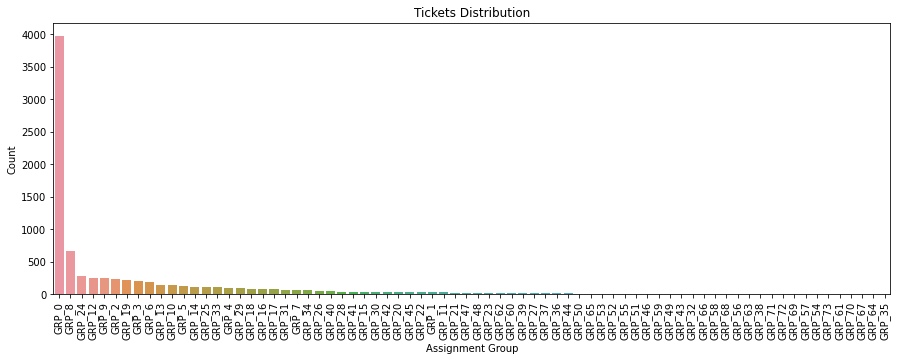

In [15]:
plt.subplots(figsize = (15,5))

sns.countplot(x='Assignment group', data=ticket_df,order = ticket_df['Assignment group'].value_counts().index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Tickets Distribution')

plt.show()

Text(0.5, 1.0, 'Distribution of Tickets')

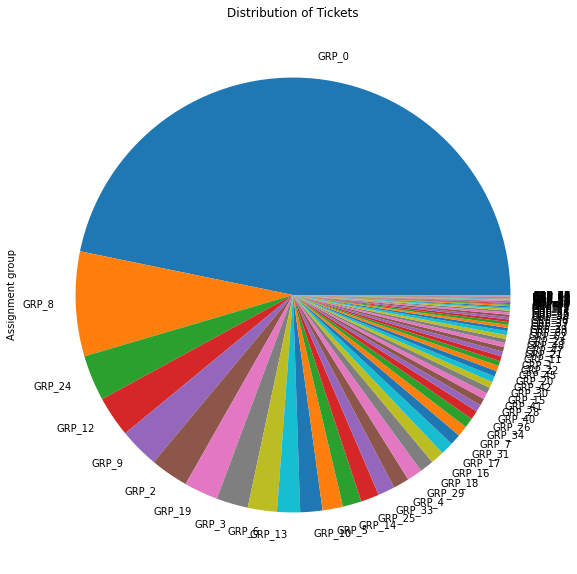

In [16]:
plt.figure(figsize=(10, 10))
ax = ticket_df['Assignment group'].value_counts().plot(kind='pie')
ax.set_title("Distribution of Tickets")

Top 25 Group with highest tickets

In [17]:
 ticket_df['Assignment group'].value_counts().head(25)

GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      184
GRP_13     145
GRP_10     140
GRP_5      129
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      81
GRP_31      69
GRP_7       68
GRP_34      62
GRP_26      56
GRP_40      45
Name: Assignment group, dtype: int64

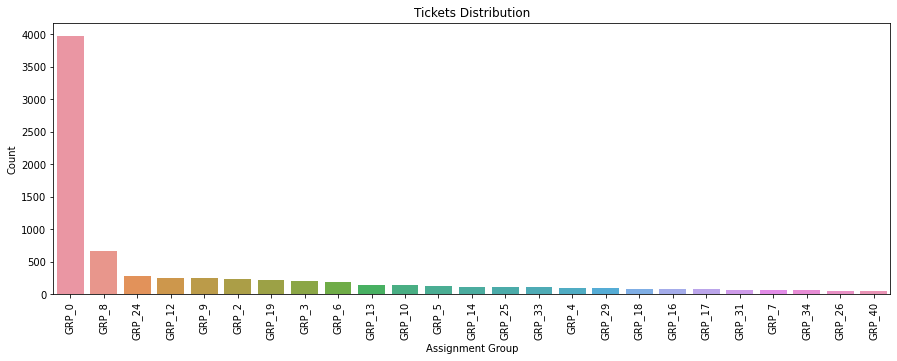

In [18]:
plt.subplots(figsize = (15,5))

sns.countplot(x='Assignment group', data=ticket_df,order = ticket_df['Assignment group'].value_counts().head(25).index)
plt.xlabel('Assignment Group') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Tickets Distribution')

plt.show()

In [19]:
#ticket_df.groupby('Assignment group').apply(lambda x: x[x.count() > 10])

In [20]:
groups = ticket_df['Assignment group'].unique()
print(f'Total group count {len(groups)}')
print(f'Group Details \n {groups}')

Total group count 74
Group Details 
 ['GRP_0' 'GRP_1' 'GRP_3' 'GRP_4' 'GRP_5' 'GRP_6' 'GRP_7' 'GRP_8' 'GRP_9'
 'GRP_10' 'GRP_11' 'GRP_12' 'GRP_13' 'GRP_14' 'GRP_15' 'GRP_16' 'GRP_17'
 'GRP_18' 'GRP_19' 'GRP_2' 'GRP_20' 'GRP_21' 'GRP_22' 'GRP_23' 'GRP_24'
 'GRP_25' 'GRP_26' 'GRP_27' 'GRP_28' 'GRP_29' 'GRP_30' 'GRP_31' 'GRP_33'
 'GRP_34' 'GRP_35' 'GRP_36' 'GRP_37' 'GRP_38' 'GRP_39' 'GRP_40' 'GRP_41'
 'GRP_42' 'GRP_43' 'GRP_44' 'GRP_45' 'GRP_46' 'GRP_47' 'GRP_48' 'GRP_49'
 'GRP_50' 'GRP_51' 'GRP_52' 'GRP_53' 'GRP_54' 'GRP_55' 'GRP_56' 'GRP_57'
 'GRP_58' 'GRP_59' 'GRP_60' 'GRP_61' 'GRP_32' 'GRP_62' 'GRP_63' 'GRP_64'
 'GRP_65' 'GRP_66' 'GRP_67' 'GRP_68' 'GRP_69' 'GRP_70' 'GRP_71' 'GRP_72'
 'GRP_73']


In [21]:
def count_ticket_within_group(ticket_count, ticket_df):
  group_groupby = ticket_df.groupby('Assignment group')
  sample = []
  for group in ticket_df['Assignment group'].unique():
    if group_groupby.get_group(group).shape[0] <= ticket_count:
      sample.append(group)
  return len(sample)

In [22]:
print(f'Total groups having 1 ticket: {count_ticket_within_group(1, ticket_df)}')
print(f'Total groups having 5 or less ticket: {count_ticket_within_group(5, ticket_df)}')
print(f'Total groups having 10 or less ticket: {count_ticket_within_group(10, ticket_df)}')
print(f'Total groups having 15 or less ticket: {count_ticket_within_group(15, ticket_df)}')

Total groups having 1 ticket: 6
Total groups having 5 or less ticket: 19
Total groups having 10 or less ticket: 25
Total groups having 15 or less ticket: 30


In [23]:
group_df = pd.DataFrame(ticket_df['Assignment group'].value_counts())
group_df = group_df.T
group_df

,GRP_0,GRP_8,GRP_24,GRP_12,GRP_9,GRP_2,GRP_19,GRP_3,GRP_6,GRP_13,GRP_10,GRP_5,GRP_14,GRP_25,GRP_33,GRP_4,GRP_29,GRP_18,GRP_16,GRP_17,GRP_31,GRP_7,GRP_34,GRP_26,GRP_40,GRP_28,GRP_41,GRP_15,GRP_30,GRP_42,GRP_20,GRP_45,GRP_22,GRP_1,GRP_11,GRP_21,GRP_47,GRP_48,GRP_23,GRP_62,GRP_60,GRP_39,GRP_27,GRP_37,GRP_36,GRP_44,GRP_50,GRP_65,GRP_53,GRP_52,GRP_55,GRP_51,GRP_46,GRP_59,GRP_49,GRP_43,GRP_32,GRP_66,GRP_58,GRP_68,GRP_56,GRP_63,GRP_38,GRP_71,GRP_72,GRP_69,GRP_57,GRP_54,GRP_73,GRP_61,GRP_70,GRP_67,GRP_64,GRP_35
Assignment group,3976,661,289,257,252,241,215,200,184,145,140,129,118,116,107,100,97,88,85,81,69,68,62,56,45,44,40,39,39,37,36,35,31,31,30,29,27,25,25,25,20,19,18,16,15,15,14,11,11,9,8,8,6,6,6,5,4,4,3,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1


GRP_0 has highest count <br>
Almost 25 groups has less than 10 tickets

In [24]:
ticket_df1 = ticket_df.copy()

In [25]:
ticket_df1.tail(10)

,Short description,Description,Caller,Assignment group
8490,check status in purchasing,please contact ed pasgryowski (pasgryo) about ...,mpihysnw wrctgoan,GRP_29
8491,vpn for laptop,\n\nreceived from: jxgobwrm.qkugdipo@gmail.com...,jxgobwrm qkugdipo,GRP_34
8492,hr_tool etime option not visitble,hr_tool etime option not visitble,tmopbken ibzougsd,GRP_0
8493,"erp fi - ob09, two accounts to be added","i am sorry, i have another two accounts that n...",ipwjorsc uboapexr,GRP_10
8494,tablet needs reimaged due to multiple issues w...,tablet needs reimaged due to multiple issues w...,cpmaidhj elbaqmtp,GRP_3
8495,emails not coming in from zz mail,\r\n\r\nreceived from: avglmrts.vhqmtiua@gmail...,avglmrts vhqmtiua,GRP_29
8496,telephony_software issue,telephony_software issue,rbozivdq gmlhrtvp,GRP_0
8497,vip2: windows password reset for tifpdchb pedx...,vip2: windows password reset for tifpdchb pedx...,oybwdsgx oxyhwrfz,GRP_0
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62
8499,an mehreren pc`s lassen sich verschiedene prgr...,an mehreren pc`s lassen sich verschiedene prgr...,kqvbrspl jyzoklfx,GRP_49


# **Explore Transform Data**

In [26]:
ticket_df_eda = ticket_df.copy()

In [27]:
ticket_df_eda.insert(1, 'sd_len', ticket_df_eda['Short description'].astype(str).apply(len))
ticket_df_eda.insert(2, 'sd_word_count', ticket_df_eda['Short description'].apply(lambda x: len(str(x).split())))
ticket_df_eda.insert(4, 'desc_len', ticket_df_eda['Description'].astype(str).apply(len))
ticket_df_eda.insert(5, 'desc_word_count', ticket_df_eda['Description'].apply(lambda x: len(str(x).split())))
ticket_df_eda.head()

,Short description,sd_len,sd_word_count,Description,desc_len,desc_word_count,Caller,Assignment group
0,login issue,11,2,-verified user details.(employee# & manager na...,206,33,spxjnwir pjlcoqds,GRP_0
1,outlook,7,1,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,194,25,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,18,5,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,87,11,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,29,5,unable to access hr_tool page,29,5,xbkucsvz gcpydteq,GRP_0
4,skype error,12,2,skype error,12,2,owlgqjme qhcozdfx,GRP_0


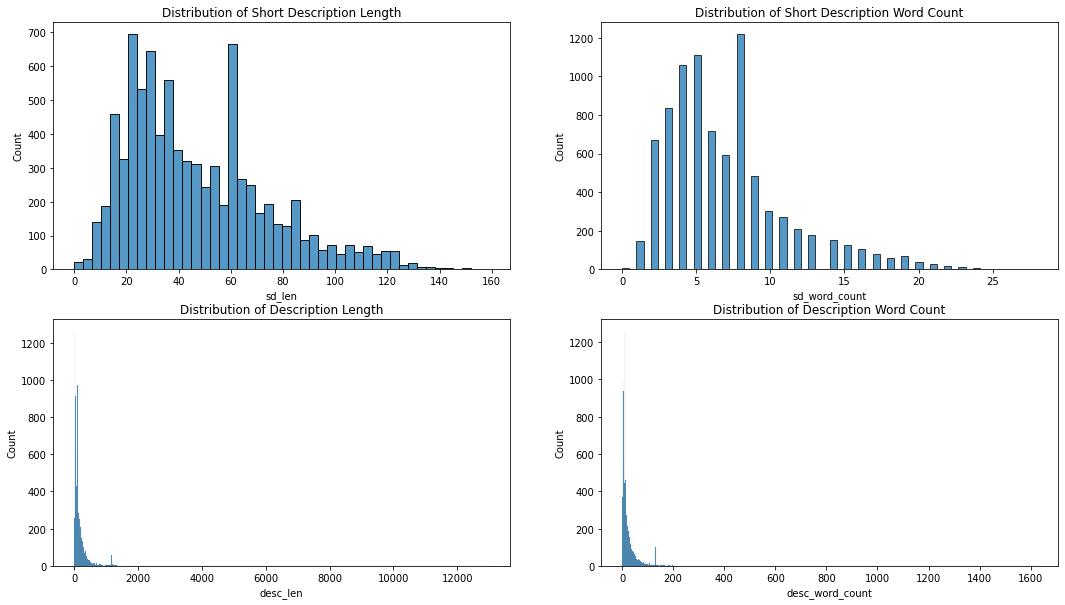

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0, 0].set_title('Distribution of Short Description Length')
sns.histplot(ticket_df_eda['sd_len'], ax=axes[0, 0])

sns.histplot(ticket_df_eda['sd_word_count'], ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Short Description Word Count')

sns.histplot(ticket_df_eda['desc_len'], ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Description Length')

sns.histplot(ticket_df_eda['desc_word_count'], ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Description Word Count')

plt.show()

**Top Caller**

In [29]:
ticket_df_eda['Caller'].value_counts()

bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
wdybmizf ekqgpaus      1
hpeknoam yrfowmva      1
qayozbcd vwglmpjq      1
crqonkxm ipyazqjx      1
scedxqur pocxqtrl      1
Name: Caller, Length: 2950, dtype: int64

In [30]:
ticket_df_eda['Caller'].value_counts().head(10)

bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
jloygrwh acvztedi     64
spxqmiry zpwgoqju     63
oldrctiu bxurpsyi     57
olckhmvx pcqobjnd     54
jyoqwxhz clhxsoqy     51
Name: Caller, dtype: int64

Top caller has recorded 810 tickets

**Top Caller in each Group**

In [31]:
top_n = 5
s = ticket_df_eda['Caller'].groupby(ticket_df_eda['Assignment group']).value_counts()
grp_caller = pd.DataFrame(s.groupby(level=0).nlargest(top_n).reset_index(level=0, drop=True))
grp_caller.head(15)

Caller
Assignment group Caller                   
GRP_0            fumkcsji sarmtlhy     132
                 rbozivdq gmlhrtvp      86
                 olckhmvx pcqobjnd      54
                 efbwiadp dicafxhv      45
                 mfeyouli ndobtzpw      13
GRP_1            bpctwhsn kzqsbmtp       6
                 jloygrwh acvztedi       4
                 jyoqwxhz clhxsoqy       3
                 spxqmiry zpwgoqju       3
                 kbnfxpsy gehxzayq       2
GRP_10           bpctwhsn kzqsbmtp      60
                 ihfkwzjd erbxoyqk       6
                 dizquolf hlykecxa       5
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3

In [32]:
# Check if any caller appears to raise ticket for multiple groups
multiple_caller = grp_caller[grp_caller.Caller.duplicated()]
unique_caller = [idx[1] for idx in multiple_caller.index[multiple_caller.Caller.unique()]]
print(f'\033[1mFollowing {len(unique_caller)} callers happen to raise tickets for multiple groups:\033[0m\n')
print(unique_caller)

multiple_caller

Following 15 callers happen to raise tickets for multiple groups:

['hlrmufzx qcdzierm', 'fbgetczn jlsvxura', 'gnasmtvx cwxtsvkm', 'ihfkwzjd erbxoyqk', 'tqfnalpj qyoscnge', 'fmqubnvs kcxpeyiv', 'tghrloks jbgcvlmf', 'jwqyxbzs adpvilqu', 'nuhfwplj ojcwxser', 'oldrctiu bxurpsyi', 'vlymsnej whlqxcst', 'dkmcfreg anwmfvlg', 'bpctwhsn kzqsbmtp', 'spxqmiry zpwgoqju', 'obanjrhg rnafleys']


Caller
Assignment group Caller                   
GRP_1            spxqmiry zpwgoqju       3
GRP_10           ihfkwzjd erbxoyqk       6
                 gnasmtvx cwxtsvkm       3
                 hlrmufzx qcdzierm       3
GRP_11           tghrloks jbgcvlmf       2
...                                    ...
GRP_73           kcnosyae zlpmfxgs       1
GRP_8            ZkBogxib QsEJzdZO      54
GRP_9            ctzykflo evzbhgru       3
                 sholvcmf bjtpomrl       3
                 urhpnlaf agmsfqil       3

[281 rows x 1 columns]

In [33]:
ticket_df.describe(percentiles=[0.1, .25, .5, .75, .95, .99]).transpose()

,count,unique,top,freq
Short description,8500,7482,password reset,38
Description,8500,7818,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


# **Garbled Text Processing**

In [41]:
ticket_df_garbled = ticket_df.copy()

In [42]:
!pip install ftfy

In [43]:
from ftfy import fix_encoding, fix_text, badness

In [44]:
# Write a function to apply to the dataset to detect Mojibakes
def is_garbled(text):
    if not badness.sequence_weirdness(text):
        # nothing weird, should be okay
        return True
    try:
        text.encode('sloppy-windows-1252')
    except UnicodeEncodeError:
        # Not CP-1252 encodable, probably fine
        return True
    else:
        # Encodable as CP-1252, Mojibake alert level high
        return False

In [45]:
ticket_df_garbled[~ticket_df_garbled.iloc[:,:-1].applymap(is_garbled).all(1)]

/usr/local/lib/python3.7/dist-packages/ftfy/badness.py:369: UserWarning: `sequence_weirdness()` is an old heuristic, and the current closest equivalent is `ftfy.badness.badness()`
  "`sequence_weirdness()` is an old heuristic, and the current "


,Short description,Description,Caller,Assignment group
99,password expiry tomorrow,\n\nreceived from: ecprjbod.litmjwsy@gmail.com...,ecprjbod litmjwsy,GRP_0
116,server issues,\r\n\r\nreceived from: bgqpotek.cuxakvml@gmail...,bgqpotek cuxakvml,GRP_0
124,mobile device activation,"from: tvcdfqgp nrbcqwgj \nsent: friday, octobe...",tvcdfqgp nrbcqwgj,GRP_0
162,access to bex,\r\n\r\nreceived from: yfqoaepn.xnezhsit@gmail...,yfqoaepn xnezhsit,GRP_0
164,æ’¤å›ž: ticket_no1564867 -- comments added,\n\nreceived from: abcdri@company.com\n\nwindy...,tycludks cjofwigv,GRP_0
...,...,...,...,...
8470,please review your recent ticketing_tool ticke...,"from: mikhghytr wafglhdrhjop \nsent: thursday,...",azxhejvq fyemlavd,GRP_16
8471,ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,to å°è´ºï¼Œæ—©ä¸Šç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥,xqyjztnm onfusvlz,GRP_30
8480,customer group enhanced field,\r\n\r\nreceived from: nlearzwi.ukdzstwi@gmail...,nlearzwi ukdzstwi,GRP_9
8498,machine nÃ£o estÃ¡ funcionando,i am unable to access the machine utilities to...,ufawcgob aowhxjky,GRP_62


In [46]:
# Take an example of row# 8471 Short Desc and fix it
print('Grabled text: ', ticket_df_garbled['Short description'][8471])
print('Fixed text: ', fix_text(ticket_df_garbled['Short description'][8471]))

Grabled text:  ç”µè„‘å¼€æœºå¼€ä¸å‡ºæ¥
Fixed text:  电脑开机开不出来


In [47]:
ticket_df_garbled['Description'] = ticket_df_garbled['Description'].apply(fix_text)
ticket_df_garbled['Short description'] = ticket_df_garbled['Short description'].apply(fix_text)

# **Identify the Languages**

In [48]:
!pip install langdetect

     |████████████████████████████████| 981 kB 25.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=efbb1b3fa93b8e5ec4f90851978f31464b6cf4919d7a0068e917bae71262d128
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [49]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

def detectLang(value):
    try:
        return detect(value)
    except (Exception):
        return "NotDetected"

In [50]:
ticket_df_garbled['lang'] = ticket_df_garbled['Description'].apply(lambda v: detectLang(v))
ticket_df_garbled['lang'].unique()

array(['en', 'no', 'fr', 'it', 'es', 'af', 'ca', 'sv', 'nl', 'fi', 'de',
       'sl', 'cy', 'id', 'et', 'pt', 'zh-cn', 'pl', 'da', 'ko', 'ro',
       'tl', 'hr', 'sq', 'sw', 'so', 'sk', 'tr', 'vi', 'lt',
       'NotDetected', 'cs', 'lv'], dtype=object)

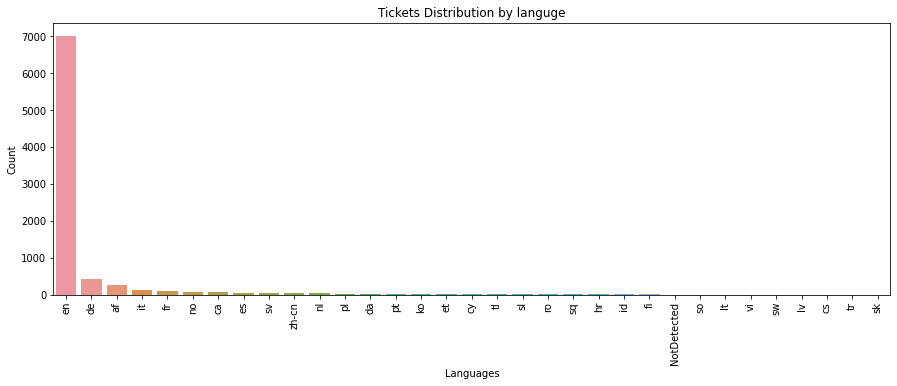

In [51]:
plt.subplots(figsize = (15,5))
sns.countplot(x='lang', data=ticket_df_garbled,order = ticket_df_garbled['lang'].value_counts().index)
plt.xlabel('Languages') 
plt.ylabel('Count') 
plt.xticks(rotation=90)
plt.title('Tickets Distribution by languge')
plt.show()

Since we are dealing with data with multiple languages, we need to perform the language translation

[]

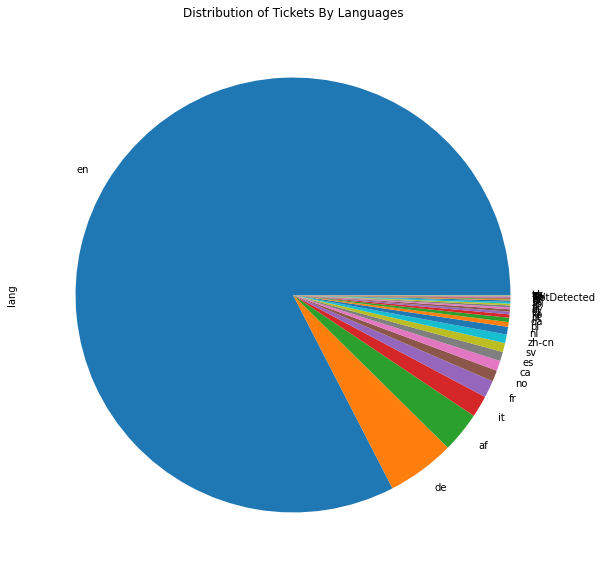

In [52]:
plt.figure(figsize=(10, 10))
ax = ticket_df_garbled['lang'].value_counts().plot(kind='pie')
ax.set_title("Distribution of Tickets By Languages")
plt.plot()

# **Translation**

**Approach 1**

In [53]:
ticket_df_trans = ticket_df_garbled.copy()

In [54]:
!pip install fasttext

     |████████████████████████████████| 68 kB 6.1 MB/s 
  Using cached pybind11-2.9.0-py2.py3-none-any.whl (210 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3126357 sha256=eb7e77f91613e560a58d0aafe1112ac72648e07ce27caf9f03927a3c37ed4716
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [55]:
!wget -O /tmp/lid.176.bin https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2022-01-17 14:41:36--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘/tmp/lid.176.bin’

/tmp/lid.176.bin    100%[===================>] 125.18M  37.5MB/s    in 3.3s    

2022-01-17 14:41:40 (37.5 MB/s) - ‘/tmp/lid.176.bin’ saved [131266198/131266198]



In [56]:
import re
#This library require the statement in one line, so converting data into single line 
def remove_newline(text):
  text = re.sub(r'\n',' ',text)
  return text
ticket_df_trans['Description'] = ticket_df_trans['Description'].apply(remove_newline)

In [58]:
#Ref :: https://amitness.com/2019/07/identify-text-language-python/

import fasttext

# pretrained model from :: https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
PRETRAINED_MODEL_PATH = '/tmp/lid.176.bin'
lang_detect_model = fasttext.load_model(PRETRAINED_MODEL_PATH)

def predict_lang(sentence):
    detected_lang = lang_detect_model.predict(sentence)[0]
    detected_lang = detected_lang[0].replace('__label__', '')
    return detected_lang;

ticket_df_trans['lang_predict'] = ticket_df_trans['Description'].apply(lambda v: predict_lang(v))
ticket_df_trans.head()

,Short description,Description,Caller,Assignment group,lang,lang_predict
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0,en,en
1,outlook,received from: hmjdrvpb.komuaywn@gmail.com ...,hmjdrvpb komuaywn,GRP_0,en,en
2,cant log in to vpn,received from: eylqgodm.ybqkwiam@gmail.com ...,eylqgodm ybqkwiam,GRP_0,en,en
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0,en,en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no,ja


In [59]:
ticket_df_trans['lang_predict'].unique()

array(['en', 'ja', 'eo', 'ko', 'zh', 'uk', 'de', 'es', 'fi', 'pt', 'hu',
       'fr', 'hr', 'nl', 'lb', 'it', 'pl', 'tr', 'id', 'sv', 'da', 'tt',
       'yue', 'war', 'sl', 'si', 'ru', 'kn'], dtype=object)

In [60]:
ticket_df_trans[ticket_df_trans['lang'] != 'en']

,Short description,Description,Caller,Assignment group,lang,lang_predict
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no,ja
14,unable to open payslips,unable to open payslips,epwyvjsz najukwho,GRP_0,fr,en
19,unable to sign into vpn,unable to sign into vpn,ftsqkvre bqzrupic,GRP_0,it,en
20,unable to check payslips,unable to check payslips,mrzgjdal whnldmef,GRP_0,fr,en
22,unable to connect to vpn,unable to connect to vpn,pfmcnahv ofzlusri,GRP_0,es,en
...,...,...,...,...,...,...
8465,vpn 连接不上,"vpn连不上,请转给 贺正平 atcbvglq.bdvmuszt@gmail.com",fcvqezmn frzyjknu,GRP_30,ko,hu
8471,电脑开机开不出来,"to 小贺,早上电脑开机开不出来",xqyjztnm onfusvlz,GRP_30,zh-cn,zh
8475,etime- time card update information.,etime- time card update information.,tmopbken ibzougsd,GRP_0,it,en
8486,ticket update on ticket_no0427635,ticket update on ticket_no0427635,fumkcsji sarmtlhy,GRP_0,sv,en


In [61]:
!pip install deep-translator

     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 97 kB 7.4 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.3 which is incompatible.


In [62]:
from deep_translator import GoogleTranslator

def translate_lang_en(to_translate, source_lang):
  if source_lang == 'en':
    return to_translate
  try:
    return GoogleTranslator(source=source_lang, target='en').translate(to_translate)
  except:
    return ""

In [63]:
ticket_df_trans['Description_en'] = ticket_df_trans.apply(lambda x: translate_lang_en(x.Description, x.lang_predict), axis=1)

In [64]:
ticket_df_trans['short_description_en'] = ticket_df_trans.apply(lambda x: translate_lang_en(x['Short description'], x.lang_predict), axis=1)

In [65]:
ticket_df_trans[ticket_df_trans['lang_predict'] != 'en'].head(10)

,Short description,Description,Caller,Assignment group,lang,lang_predict,Description_en,short_description_en
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no,ja,skype error,skype error
39,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0,ca,eo,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty
51,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0,ca,eo,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty
126,blank call //gso,blank call //gso,rbozivdq gmlhrtvp,GRP_0,en,ko,blank call //gso,blank call //gso
164,撤回: ticket_no1564867 -- comments added,received from: abcdri@company.com windy shi...,tycludks cjofwigv,GRP_0,en,zh,,
213,loud noise // gso,loud noise // gso,rbozivdq gmlhrtvp,GRP_0,fr,uk,loud noise // gso,loud noise // gso
222,support für fa.gstry \arexjftu ohxdwngl,support für fa.konnica \arexjftu ohxdwngl,arexjftu ohxdwngl,GRP_24,en,de,support for fa.konnica \arexjftu ohxdwngl,support for fa.gstry \arexjftu ohxdwngl
223,probleme mit bluescreen .,"hallo , es ist erneut passiert. der pc hat si...",vrfpyjwi nzhvgqiw,GRP_24,de,de,"hello, it happened again. the pc hung up again...",problems with blue screen .
229,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0,ca,eo,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty
251,reset the password for fygrwuna gomcekzi on e-...,bitte passwort für fygrwuna gomcekzi e-mail zu...,fygrwuna gomcekzi,GRP_0,de,de,please reset password for fygrwuna gomcekzi em...,reset the password for fygrwuna gomcekzi on e-...


**Approach 2**

In [66]:
!pip install google_trans_new

In [67]:
from langdetect import detect
from google_trans_new import google_translator  

#simple function to detect and translate text 
def detect_and_translate(text,target_lang):
    
    if target_lang == 'en':
      return text
    try:
      result_lang = detect(text)
    except:
      print(f'Error in detection: {text}')
      return text
    
    if result_lang == target_lang:
        return text    
    else:
        translator = google_translator()
        translate_text = translator.translate(text,lang_src=result_lang,lang_tgt=target_lang)
        return translate_text 

In [68]:
ticket_df_trans['Description_en_1'] = ticket_df_trans.apply(lambda x: detect_and_translate(x.Description, x.lang), axis=1)

Error in detection: 
Error in detection: +86  
Error in detection:    
Error in detection:  


In [69]:
ticket_df_trans['short_description_en_1'] = ticket_df_trans.apply(lambda x: translate_lang_en(x['Short description'], x.lang_predict), axis=1)

In [70]:
ticket_df_trans[ticket_df_trans['lang_predict'] != 'en'].head(5)

,Short description,Description,Caller,Assignment group,lang,lang_predict,Description_en,short_description_en,Description_en_1,short_description_en_1
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0,no,ja,skype error,skype error,skype error,skype error
39,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0,ca,eo,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty
51,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,olckhmvx pcqobjnd,GRP_0,ca,eo,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty,call for ecwtrjnq jpecxuty
126,blank call //gso,blank call //gso,rbozivdq gmlhrtvp,GRP_0,en,ko,blank call //gso,blank call //gso,blank call //gso,blank call //gso
164,撤回: ticket_no1564867 -- comments added,received from: abcdri@company.com windy shi...,tycludks cjofwigv,GRP_0,en,zh,,,received from: abcdri@company.com windy shi...,


**Approach 3** <br>
There is limit to convert the word so this is not being used

In [71]:
# Define and construct the service urls
svc_domains = ['.com','.com.au','.com.ar','.co.kr','.co.in','.co.jp','.at','.de','.ru','.ch','.fr','.es','.ae']
svc_urls = ['http://translate.google' + domain for domain in svc_domains]

In [72]:
# List of column data to consider for translation
#trans_cols = ['Short description','Description']

# Add a new column to store the detected language
ticket_df.insert(loc=2, column='Language', value=np.nan, allow_duplicates=True)

#for idx in range(ticket_df.shape[0]):
    # Instantiate Goslate class in each iteration
#    gs = Goslate(service_urls=svc_urls)
#    lang = gs.detect(' '.join(ticket_df.loc[idx, trans_cols].tolist()))
#    row_iter = gs.translate(ticket_df.loc[idx, trans_cols].tolist(), 
#                            target_language='en', 
#                            source_language='auto')
#    ticket_df.loc[idx, trans_cols] = list(row_iter)
    
#ticket_df.Language = lang
#ticket_df.head()

# **Text Preprocessing**

In [73]:
ticket_df_processing = ticket_df_trans.copy()

In [74]:
from dateutil import parser
import re
import string

def lower_case(text):
  return text.lower()
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False
def remove_email(text):
  text = re.sub(r'\S*@\S*\s?', '', text)
  return text
def remove_number(text):
  text = re.sub(r'\d+','' ,text)
  return text
def remove_newline(text):
  text = re.sub(r'\n',' ',text)
  return text
def remove_special(text):
  text = re.sub(r'#','', text)
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = re.sub(r'\s+', ' ', text)
  return text
def remove_hyperlink(text):
  text = re.sub(r'https?:\/\/.*\/\w*', '', text)
  return text
def extract_email(text):
  email_dict = get_email(text)
  for key in email_dict.keys():
    text = text.replace(email_dict[key], key)
  return text, email_dict
def add_email(text, email_dict):
  for key in email_dict.keys():
    text = text.replace(key, email_dict[key])
  return text
def get_email(text):
    # Replaces the email addresses with custom key word and 
    # save them into a dictionary for future use
    EMAIL_PATTERN = r"([\w.+-]+@[a-z\d-]+\.[a-z\d.-]+)"
    unique_emailid = set(re.findall(EMAIL_PATTERN, text))
    email_replacement = dict()
    for idx, email in enumerate(unique_emailid):
        email_replacement[f'RetainedEmailId{idx}'] = email
    return email_replacement
def clean_text(text):
  text = lower_case(text)
  text, email_dict = extract_email(text)
  text = ' '.join([w for w in text.split() if not is_valid_date(w)])
  #text = remove_email(text)
  text = remove_newline(text)
  text = remove_special(text)
  text = remove_hyperlink(text)
  text = add_email(text, email_dict)
  text = remove_number(text)
  return text.strip()

In [75]:
print(ticket_df_processing['Description'][32])

  received from: kxsceyzo.naokumlb@gmail.com  gentles,  i have two devices that are trying to share an ip address. they are trying to share 96.26.27.9619. one is a printer with the hostname of prtjc0074, and the other is a new display for erp. the display is using dhcp to get its address assigned and the printer is hard coded.  my guess is that the address 96.26.27.9619 did not get set to a static address in dhcp. i need this corrected so the display will pick up another address.  


In [76]:
ticket_df_processing['Description'] = ticket_df_processing['Description'].apply(clean_text)
ticket_df_processing['Description_en'] = ticket_df_processing['Description_en'].apply(clean_text)
ticket_df_processing['Description_en_1'] = ticket_df_processing['Description_en_1'].apply(clean_text)

In [77]:
ticket_df_processing['Short description'] =  ticket_df_processing['Short description'].apply(clean_text)
ticket_df_processing['short_description_en'] =  ticket_df_processing['short_description_en'].apply(clean_text)
ticket_df_processing['short_description_en_1'] =  ticket_df_processing['short_description_en_1'].apply(clean_text)

In [78]:
print(ticket_df_processing['Description_en_1'][32])

received from kxsceyzo.naokumlb@gmail.com gentles i have two devices that are trying to share an ip address they are trying to share  one is a printer with the hostname of prtjc and the other is a new display for erp the display is using dhcp to get its address assigned and the printer is hard coded my guess is that the address  did not get set to a static address in dhcp i need this corrected so the display will pick up another address


We have performed the data clearning activity

# **Stemming & Lemmatization**

In [79]:
ticket_df_slt = ticket_df_processing.copy()

In [80]:
!pip install spacy

**Combine Description and Short Description**

Approach 1 has given better translation, so we will use the same columm for further processing

In [81]:
ticket_df_slt['combine_description']=ticket_df_slt['short_description_en'].astype(str) + ' ' +ticket_df_slt['Description_en'].astype(str)

In [82]:
ticket_df_slt[ticket_df_slt['lang'] != 'en'].tail(10)

,Short description,Description,Caller,Assignment group,lang,lang_predict,Description_en,short_description_en,Description_en_1,short_description_en_1,combine_description
8429,new email problem,new email problem,ythucdjx mujfrsyl,GRP_19,cy,en,new email problem,new email problem,new email problem,new email problem,new email problem new email problem
8439,der drucker für die upslapels druckt nicht ric...,der drucker steht am platz von wckrxovs aunsgzmd,kiqrvwat gwkpxzyt,GRP_33,de,de,the printer is in the place of wckrxovs aunsgzmd,the printer for the upslapels does not print c...,der drucker steht am platz von wckrxovs aunsgzmd,the printer for the upslapels does not print c...,the printer for the upslapels does not print c...
8451,password reset erp sid,password reset erp sid,rcukxbvw pvnuqlyb,GRP_0,af,en,password reset erp sid,password reset erp sid,password reset erp sid,password reset erp sid,password reset erp sid password reset erp sid
8457,无法登陆hrtool考勤系统,显示java插件无法加载所需版本或更高版本。,kyagjxdh dmtjpbnz,GRP_30,ko,zh,,,显示java插件无法加载所需版本或更高版本。,,
8461,reboot lhqsm patent web uacyltoe hxgaycze serv...,reboot lhqsm patent web uacyltoe hxgaycze serv...,uvrbhlnt bjrmalzi,GRP_8,nl,en,reboot lhqsm patent web uacyltoe hxgaycze serv...,reboot lhqsm patent web uacyltoe hxgaycze serv...,reboot lhqsm patent web uacyltoe hxgaycze serv...,reboot lhqsm patent web uacyltoe hxgaycze serv...,reboot lhqsm patent web uacyltoe hxgaycze serv...
8465,vpn 连接不上,vpn连不上请转给 贺正平 atcbvglq.bdvmuszt@gmail.com,fcvqezmn frzyjknu,GRP_30,ko,hu,vpn 连不上 请 转给 贺正平 atcbvglq.bdvmuszt@gmail.com,vpn 连接 不 上,vpn连不上请转给 贺正平 atcbvglq.bdvmuszt@gmail.com,vpn 连接 不 上,vpn 连接 不 上 vpn 连不上 请 转给 贺正平 atcbvglq.bdvmuszt@...
8471,电脑开机开不出来,to 小贺早上电脑开机开不出来,xqyjztnm onfusvlz,GRP_30,zh-cn,zh,,,to 小贺早上电脑开机开不出来,,
8475,etime time card update information,etime time card update information,tmopbken ibzougsd,GRP_0,it,en,etime time card update information,etime time card update information,etime time card update information,etime time card update information,etime time card update information etime time ...
8486,ticket update on ticketno,ticket update on ticketno,fumkcsji sarmtlhy,GRP_0,sv,en,ticket update on ticketno,ticket update on ticketno,ticket update on ticketno,ticket update on ticketno,ticket update on ticketno ticket update on tic...
8499,an mehreren pcs lassen sich verschiedene prgra...,an mehreren pcs lassen sich verschiedene prgra...,kqvbrspl jyzoklfx,GRP_49,de,de,different programs cannot be opened on several...,different programs cannot be opened on several...,an mehreren pcs lassen sich verschiedene prgra...,different programs cannot be opened on several...,different programs cannot be opened on several...


In [83]:
ticket_df_slt.iloc[8499]['combine_description']

'different programs cannot be opened on several pcs different programs cannot be opened on several pcs area cnc'

In [84]:
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

stopwords_eng = stopwords.words('english')
for i,text in enumerate(ticket_df_slt['combine_description']):
  ticket_df_slt['combine_description'][i]=" ".join(word for word in text.split(' ') if word not in stopwords_eng)
 

nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [85]:
ticket_df_slt['combine_description'] = ticket_df_slt['combine_description'].apply(lemmatize_text)

In [86]:
ticket_df_slt['combine_description'][8499]

'different program can not open several pc different program can not open several pc area cnc'

# **NGram**

In [91]:
ticket_df_ngram = ticket_df_slt.copy()

In [92]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [93]:
def get_top_n_ngrams(corpus, top_n=None, ngram_range=(1,1), stopwords=None):
    vec = CountVectorizer(ngram_range=ngram_range, 
                          stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_n]

**Unigrams**

In [96]:
top_n = 50
ngram_range = (1,1)
uni_grams = get_top_n_ngrams(ticket_df_ngram.combine_description, top_n, ngram_range, stopwords=stopwords_eng)

unigram_df = pd.DataFrame(uni_grams, columns = ['words' , 'count'])
uni_top = unigram_df.head(10)
uni_top.head()

,words,count
0,com,3162
1,job,3067
2,receive,2564
3,please,2337
4,password,2187


**BiGram**

In [97]:
top_n = 50
bigram_range = (2,2)
bi_grams = get_top_n_ngrams(ticket_df_ngram.combine_description, top_n, bigram_range, stopwords=stopwords_eng)

bigram_df = pd.DataFrame(bi_grams, columns = ['words' , 'count'])
bi_top = bigram_df.head(10)
bi_top.head()

,words,count
0,gmail com,1980
1,fail jobscheduler,1614
2,company com,1131
3,receive monitoring_tool,961
4,monitoring_tool company,961


**TriGram**

In [98]:
top_n = 50
trigram_range = (3,3)
tri_grams = get_top_n_ngrams(ticket_df_ngram.combine_description, top_n, trigram_range, stopwords=stopwords_eng)

trigram_df = pd.DataFrame(tri_grams, columns = ['words' , 'count'])
tri_top = trigram_df.head(10)
tri_top.head()

,words,count
0,receive monitoring_tool company,961
1,monitoring_tool company com,961
2,job job fail,884
3,job fail jobscheduler,884
4,fail jobscheduler receive,803


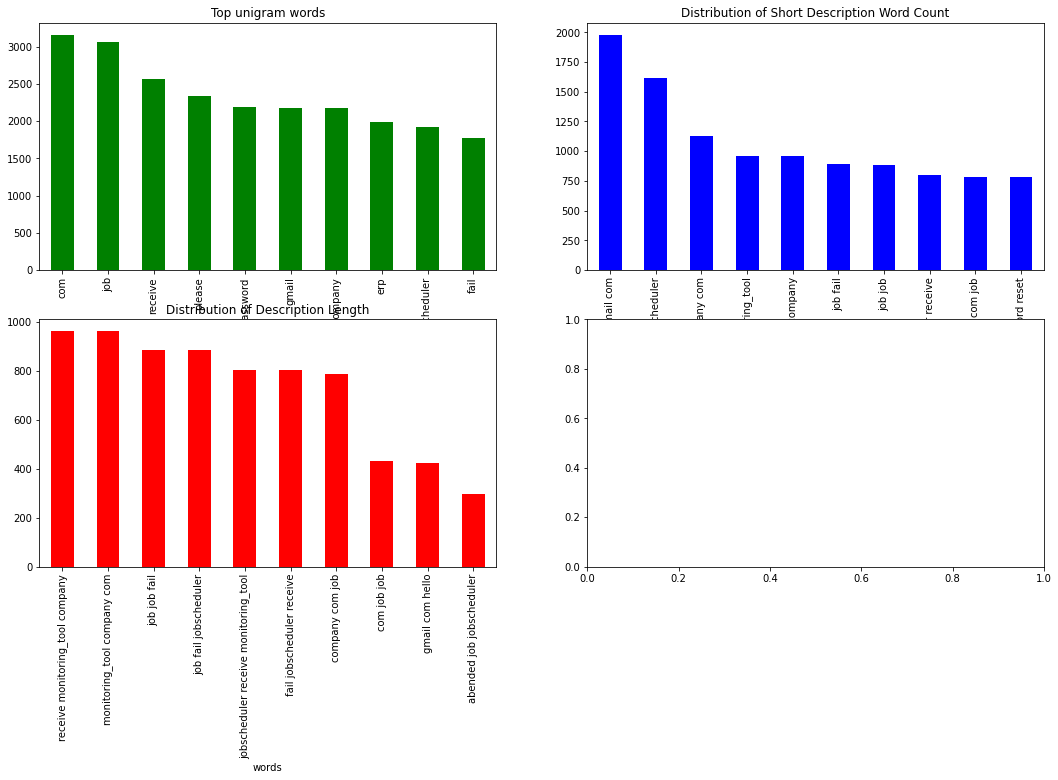

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0, 0].set_title('Top unigram words')
#sns.histplot(ticket_df_eda['sd_len'], ax=axes[0, 0])
uni_top.groupby('words').sum()['count'].sort_values(ascending=False).plot(kind='bar',color='green', ax=axes[0, 0])

bi_top.groupby('words').sum()['count'].sort_values(ascending=False).plot(kind='bar',color='blue', ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Short Description Word Count')

tri_top.groupby('words').sum()['count'].sort_values(ascending=False).plot(kind='bar',color='red', ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Description Length')

plt.show()

# **WordCloud**

In [102]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def generate_word_clod(corpus):
    # mask = np.array(Image.open('cloud2.png'))
    # Instantiate the wordcloud object
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords=stopwords_eng,
                    # mask=mask,
                    min_font_size = 10).generate(corpus)

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

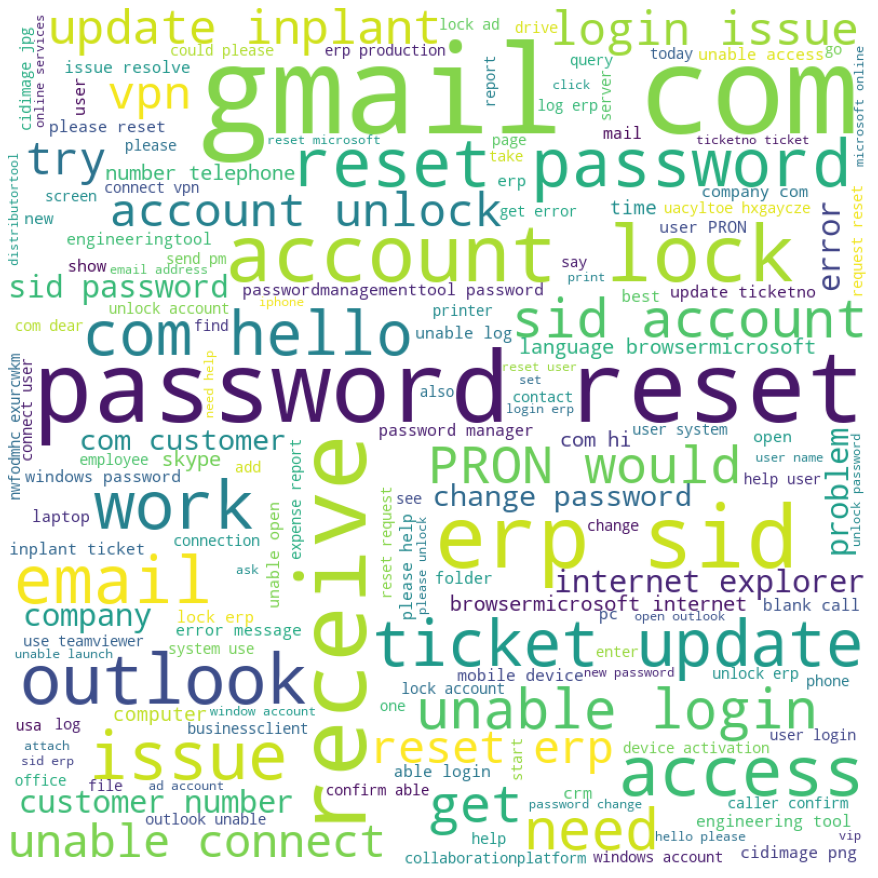

In [103]:
generate_word_clod(' '.join(ticket_df_ngram[ticket_df_ngram['Assignment group'] == 'GRP_0'].combine_description.str.strip()))

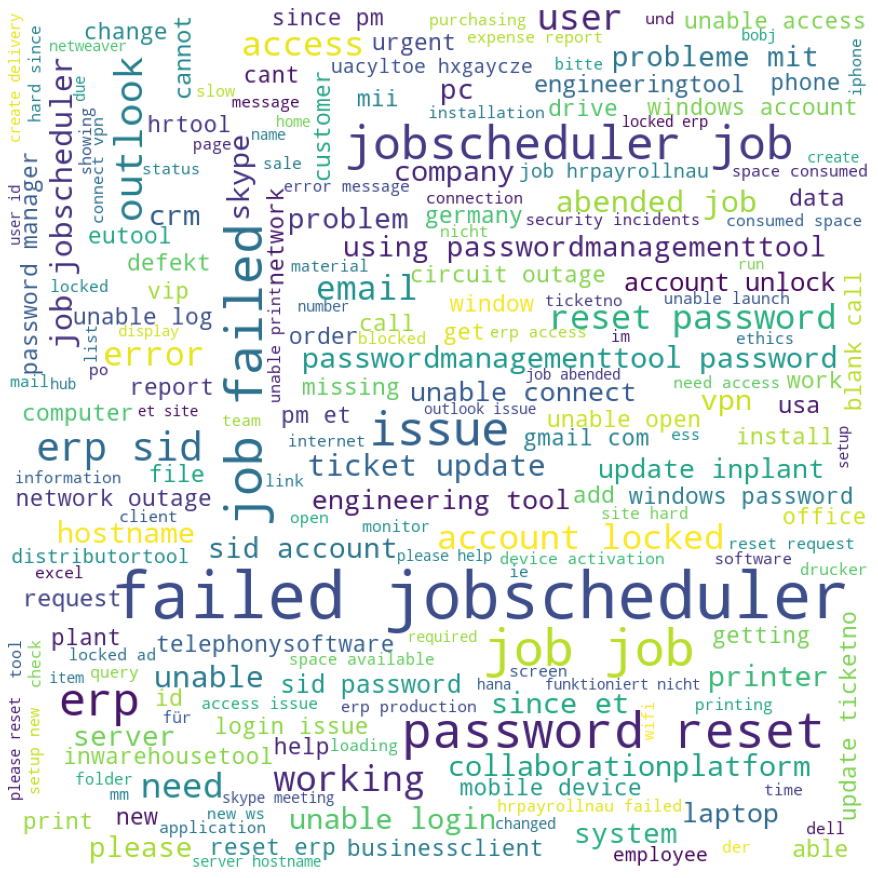

In [104]:
# Generate wordcloud for ticket Short description
generate_word_clod(' '.join(ticket_df_ngram['Short description'].str.strip()))

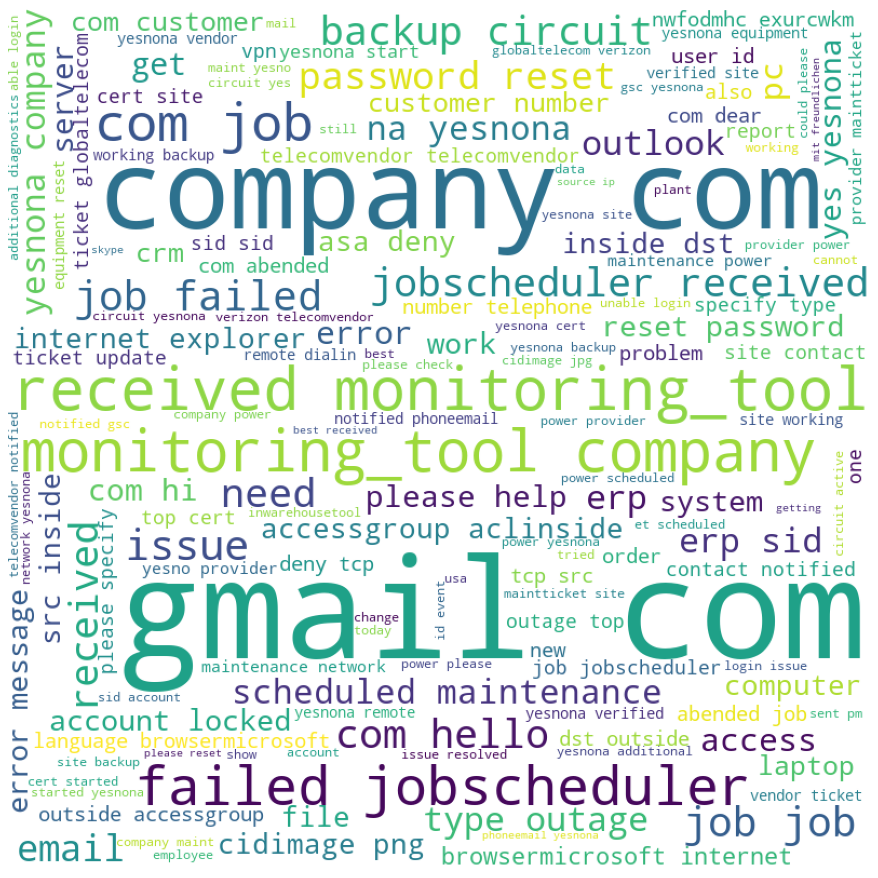

In [105]:
generate_word_clod(' '.join(ticket_df_ngram.Description.str.strip()))

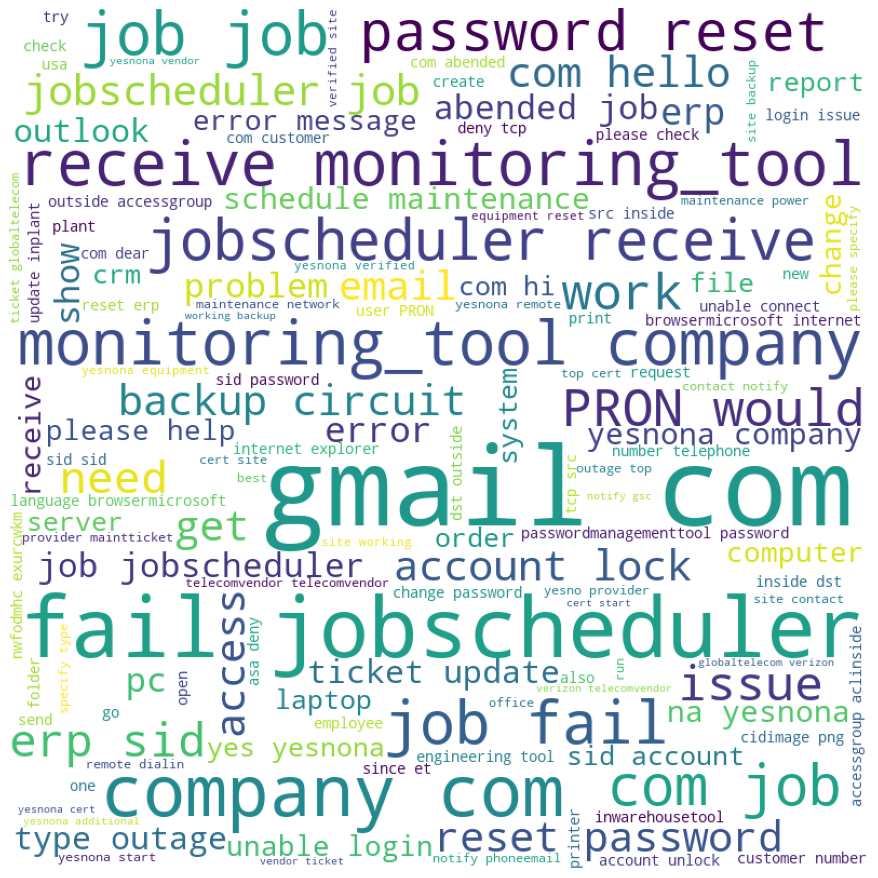

In [106]:
# Generate wordcloud for ticket Summary
generate_word_clod(' '.join(ticket_df_ngram.combine_description.str.strip()))

In [108]:
ticket_df_final = ticket_df_ngram

In [110]:
# Create a target categorical column
ticket_df_final['target'] = ticket_df_final['Assignment group'].astype('category').cat.codes
ticket_df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8500 entries, 0 to 8499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Short description       8500 non-null   object
 1   Description             8500 non-null   object
 2   Caller                  8500 non-null   object
 3   Assignment group        8500 non-null   object
 4   lang                    8500 non-null   object
 5   lang_predict            8500 non-null   object
 6   Description_en          8500 non-null   object
 7   short_description_en    8500 non-null   object
 8   Description_en_1        8500 non-null   object
 9   short_description_en_1  8500 non-null   object
 10  combine_description     8500 non-null   object
 11  target                  8500 non-null   int8  
dtypes: int8(1), object(11)
memory usage: 1.1+ MB


In [111]:
# A class that logs the time
class Timer():
    '''
    A generic class to log the time
    '''
    def __init__(self):
        self.start_ts = None
    def start(self):
        self.start_ts = time()
    def stop(self):
        return 'Time taken: %2fs' % (time()-self.start_ts)
    
timer = Timer()

# A method that plots the Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

# A method to train and test the model
def run_classification(estimator, X_train, X_test, y_train, y_test, arch_name=None, pipelineRequired=True, isDeepModel=False):
    timer.start()
    # train the model
    clf = estimator

    if pipelineRequired :
        clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', estimator),
                     ])
      
    if isDeepModel :
        clf.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=10, batch_size=128,verbose=1,callbacks=call_backs(arch_name))
        # predict from the claffier
        y_pred = clf.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_train_pred = clf.predict(X_train)
        y_train_pred = np.argmax(y_train_pred, axis=1)
    else :
        clf.fit(X_train, y_train)
        # predict from the claffier
        y_pred = clf.predict(X_test)
        y_train_pred = clf.predict(X_train)
    
    print('Estimator:', clf)
    print('='*80)
    print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred) * 100))
    print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('='*80)
    print('Confusion matrix:\n %s' % (confusion_matrix(y_test, y_pred)))
    print('='*80)
    print('Classification report:\n %s' % (classification_report(y_test, y_pred)))
    print(timer.stop(), 'to run the model')

In [114]:
# Create training and test datasets with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(ticket_df_final.combine_description, 
                                                    ticket_df_final.target, 
                                                    test_size=0.20, 
                                                    random_state=42)
print('\033[1mShape of the training set:\033[0m', X_train.shape, X_test.shape)
print('\033[1mShape of the test set:\033[0m', y_train.shape, y_test.shape)

Shape of the training set: (6800,) (1700,)
Shape of the test set: (6800,) (1700,)


In [119]:
run_classification(MultinomialNB(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])
Training accuracy: 56.66%
Testing accuracy: 52.82%
Confusion matrix:
 [[761   0   0 ...   0   0   0]
 [  3   0   0 ...   0   2   0]
 [ 15   0   0 ...   0   9   0]
 ...
 [  1   0   0 ...   0   0   0]
 [ 13   0   0 ...   0 108   0]
 [ 17   0   0 ...   0  38   0]]
Classification report:
               precision    recall  f1-score   support

           0       0.53      1.00      0.69       761
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00         5
           4       0.56      0.24      0.33        42
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
run_classification(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])
Training accuracy: 48.74%
Testing accuracy: 37.94%
Confusion matrix:
 [[432   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  1   0   8 ...   0   0   1]
 ...
 [  1   0   0 ...   0   0   0]
 [  0   0   2 ...   0  83   9]
 [  1   0   0 ...   0  28  11]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.57      0.67       761
           1       0.00      0.00      0.00         8
           2       0.80      0.33      0.47        24
           3       0.00      0.00      0.00         5
           4       0.52      0.33      0.41        42
           5       0.00      0.00      0.00        26
           6       1.00      0.15      0.26        20
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        20
           9       0.40      0.12   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [121]:
# SVM with Linear kernel
run_classification(LinearSVC(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])
Training accuracy: 92.06%
Testing accuracy: 67.41%
Confusion matrix:
 [[715   0   1 ...   0   0   3]
 [  0   0   0 ...   0   1   0]
 [  3   0  15 ...   0   1   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  1   1   2 ...   0 104   1]
 [  7   0   0 ...   0  35  10]]
Classification report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83       761
           1       0.00      0.00      0.00         8
           2       0.62      0.62      0.62        24
           3       0.33      0.20      0.25         5
           4       0.51      0.60      0.55        42
           5       0.68      0.58      0.62        26
           6       0.45      0.45      0.45        20
           7       1.00      0.12      0.22         8
           8       0.43      0.15      0.22        20
           9       0.89      1.00      0.94    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [122]:
# SVM with RBF kernel
run_classification(SVC(kernel='rbf'), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC())])
Training accuracy: 82.15%
Testing accuracy: 62.12%
Confusion matrix:
 [[751   0   0 ...   0   0   0]
 [  1   0   0 ...   0   2   0]
 [ 13   0   9 ...   0   0   1]
 ...
 [  1   0   0 ...   0   0   0]
 [  7   0   2 ...   0  98   8]
 [ 16   0   0 ...   0  28  10]]
Classification report:
               precision    recall  f1-score   support

           0       0.61      0.99      0.75       761
           1       0.00      0.00      0.00         8
           2       0.82      0.38      0.51        24
           3       0.00      0.00      0.00         5
           4       0.50      0.45      0.48        42
           5       0.64      0.27      0.38        26
           6       1.00      0.25      0.40        20
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        20
           9       1.00      1.00      1.00        17

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
run_classification(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])
Training accuracy: 94.78%
Testing accuracy: 59.06%
Confusion matrix:
 [[643   0   5 ...   0   1   1]
 [  1   1   0 ...   0   1   0]
 [  9   0   8 ...   0   0   1]
 ...
 [  1   0   0 ...   0   0   0]
 [  1   1   2 ...   0  93   7]
 [  8   0   0 ...   0  28  12]]
Classification report:
               precision    recall  f1-score   support

           0       0.73      0.84      0.79       761
           1       0.50      0.12      0.20         8
           2       0.35      0.33      0.34        24
           3       0.00      0.00      0.00         5
           4       0.46      0.50      0.48        42
           5       0.32      0.27      0.29        26
           6       0.10      0.10      0.10        20
           7       0.17      0.12      0.14         8
           8       0.47      0.40      0.43        20
           9       1.00      1.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [124]:
run_classification(RandomForestClassifier(n_estimators=100), X_train, X_test, y_train, y_test)

Estimator: Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])
Training accuracy: 94.78%
Testing accuracy: 63.00%
Confusion matrix:
 [[747   0   0 ...   0   1   0]
 [  2   0   0 ...   0   1   0]
 [ 12   0   9 ...   0   0   1]
 ...
 [  1   0   0 ...   0   0   0]
 [  2   1   2 ...   0 100   8]
 [ 16   0   0 ...   0  28  10]]
Classification report:
               precision    recall  f1-score   support

           0       0.63      0.98      0.77       761
           1       0.00      0.00      0.00         8
           2       0.82      0.38      0.51        24
           3       0.00      0.00      0.00         5
           4       0.56      0.48      0.51        42
           5       0.45      0.19      0.27        26
           6       0.83      0.25      0.38        20
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        20
           9       1.00      1.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
